In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines as lflns
sns.set_style('whitegrid')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

In [ ]:
# Load training data and impute categorical variables.

hct_df = pd.read_csv("../data/train_set.csv")

# Replace text value that corresponding so missing data with NaN
hct_df = hct_df.replace(to_replace=["Missing Disease Status", "Missing disease status"], value=np.nan)

# drop columns that aren't appropriate for prediction
hct_df = hct_df.drop(columns=['ID', 'year_hct'])

(23040, 58)

In [ ]:
feat_names = hct_df.columns[:-2]
target_names = ['efs', 'efs_time']
cat_cols = list(hct_df.select_dtypes(include='O').columns)
to_scale = ['donor_age', 'age_at_hct', 'karnofsky_score']

n_splits=5
kfold = KFold(n_splits=n_splits, shuffle=True)
scores = np.zeros(n_splits)

from lifelines import CoxPHFitter

for num, (train_idx, test_idx) in enumerate(kfold.split(hct_df)):
    
    train = hct_df.iloc[train_idx]
    test = hct_df.iloc[test_idx]

    pipeline = Pipeline(
        [
            (
                "encode and scale",
                ColumnTransformer(
                    [
                        ('one_hot', OneHotEncoder(drop='first', min_frequency=0.001, handle_unknown='ignore'), cat_cols),
                        ('scale', StandardScaler(), to_scale)
                    ],
                    sparse_threshold=0,
                    remainder='passthrough',
                    verbose_feature_names_out=False,
                    force_int_remainder_cols=False
                )
            ),
            (
                "impute",
                KNNImputer()
            ),
        ]
    )

    X_train_proc = pd.DataFrame(pipeline.fit_transform(train[feat_names]), columns=pipeline.get_feature_names_out()).set_index(train_idx)
    y_train_proc = train[target_names]
    train_proc = pd.concat([X_train_proc, y_train_proc], axis=1)

    X_test_proc = pd.DataFrame(pipeline.transform(test[feat_names]), columns=pipeline.get_feature_names_out()).set_index(test_idx)
    y_test_proc = test[target_names]
    test_proc = pd.concat([X_test_proc, y_test_proc], axis=1)

    cph = CoxPHFitter()
    cph.fit(train_proc, duration_col='efs_time', event_col='efs')
    scores[num] = cph.concordance_index_

print(scores)

/home/raykarpman/anaconda3/envs/erdos_sp25_post_hct/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[0.67738495 0.67525298 0.67601588 0.67760103 0.67634688]


In [81]:
X_train_proc = pd.DataFrame(pipeline.fit_transform(hct_df[feat_names]), columns=pipeline.get_feature_names_out())
y_train_proc = hct_df[target_names]
train_proc = pd.concat([X_train_proc, y_train_proc], axis=1)

In [82]:
cph = CoxPHFitter()
cph.fit(train_proc, duration_col='efs_time', event_col='efs')
scores[num] = cph.concordance_index_

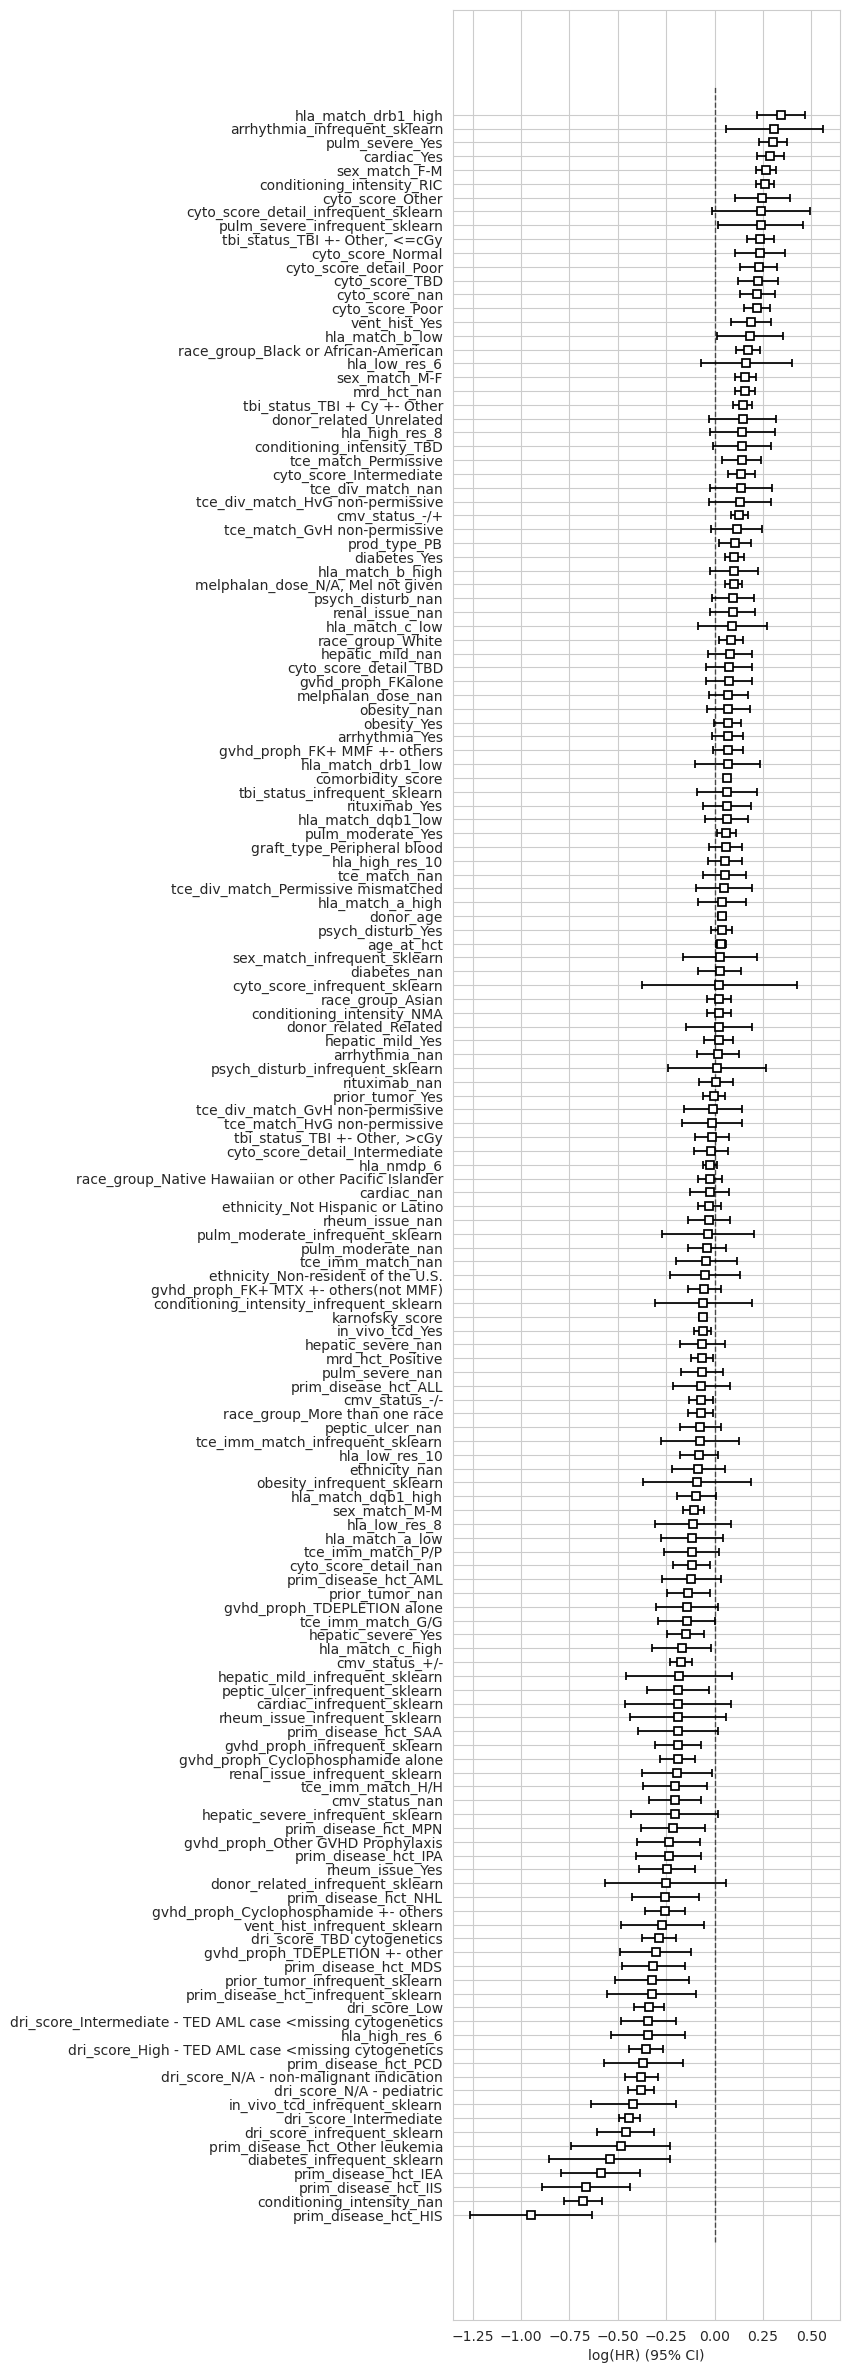

In [83]:
plt.figure(figsize=(5, 30))
cph.plot()
plt.show()

In [84]:
coefficient_info = pd.concat([cph.params_, cph.confidence_intervals_], axis=1).reset_index()
coefficient_info['abs_coef'] = abs(coefficient_info['coef'])
coefficient_info['zero not in conf int'] = coefficient_info['95% lower-bound'] * coefficient_info['95% upper-bound'] > 0
coefficient_info = coefficient_info.sort_values(by='covariate', ascending=False)

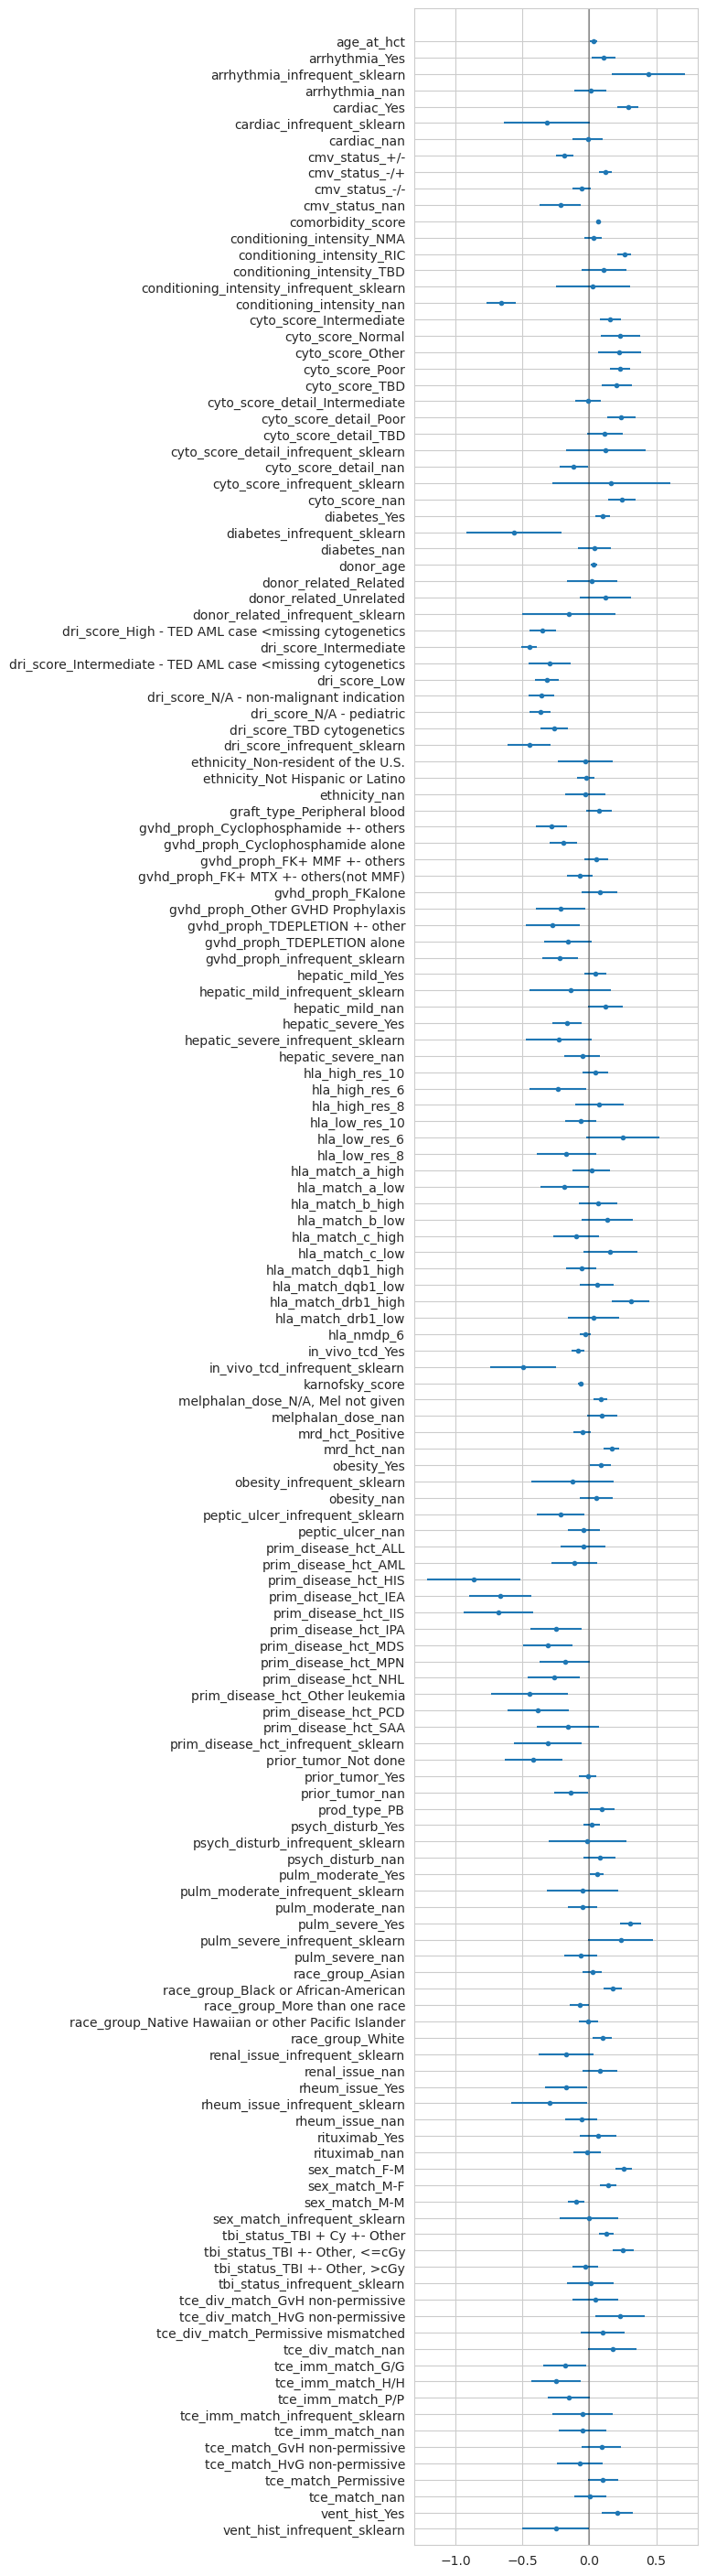

In [77]:
num_coefs = coefficient_info.shape[0]

fig, ax = plt.subplots(figsize=(4, 36))
lower_error = (coefficient_info['coef'] - coefficient_info['95% lower-bound']).values,
upper_error = (coefficient_info['95% upper-bound'] - coefficient_info['coef']).values
errors = np.vstack((lower_error, upper_error))
ax.errorbar(coefficient_info['coef'], np.arange(num_coefs), xerr=errors, fmt='.')
plt.yticks(np.arange(num_coefs), coefficient_info['covariate'])
plt.ylim(-1, num_coefs + 1)
ax.axvline(x=0, color='black', alpha=0.3)
plt.show()

In [85]:
significant_coefs = coefficient_info.loc[coefficient_info['zero not in conf int']]
significant_coefs = significant_coefs.sort_values(by='coef', ascending=False)

In [86]:
significant_coefs.shape

(76, 6)

In [89]:
key_columns = significant_coefs.covariate.to_list() + ['efs', 'efs_time']
for col in key_columns:
    print(col)

hla_match_drb1_high
arrhythmia_infrequent_sklearn
pulm_severe_Yes
cardiac_Yes
sex_match_F-M
conditioning_intensity_RIC
cyto_score_Other
pulm_severe_infrequent_sklearn
tbi_status_TBI +- Other, <=cGy
cyto_score_Normal
cyto_score_detail_Poor
cyto_score_TBD
cyto_score_nan
cyto_score_Poor
vent_hist_Yes
hla_match_b_low
race_group_Black or African-American
sex_match_M-F
mrd_hct_nan
tbi_status_TBI + Cy +- Other
tce_match_Permissive
cyto_score_Intermediate
cmv_status_-/+
prod_type_PB
diabetes_Yes
melphalan_dose_N/A, Mel not given
race_group_White
comorbidity_score
pulm_moderate_Yes
donor_age
age_at_hct
karnofsky_score
in_vivo_tcd_Yes
mrd_hct_Positive
cmv_status_-/-
race_group_More than one race
sex_match_M-M
cyto_score_detail_nan
prior_tumor_nan
hepatic_severe_Yes
hla_match_c_high
cmv_status_+/-
peptic_ulcer_infrequent_sklearn
gvhd_proph_infrequent_sklearn
gvhd_proph_Cyclophosphamide alone
renal_issue_infrequent_sklearn
tce_imm_match_H/H
cmv_status_nan
prim_disease_hct_MPN
gvhd_proph_Other GVHD

In [97]:
# Fox a cox regression model out of the box
from lifelines import CoxPHFitter
cph2 = CoxPHFitter()
cph2.fit(df_key, duration_col='efs_time', event_col='efs')

<lifelines.CoxPHFitter: fitted with 23040 total observations, 10612 right-censored observations>

In [98]:
cph2.print_summary()

<lifelines.CoxPHFitter: fitted with 23040 total observations, 10612 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
      baseline estimation = breslow
   number of observations = 23040
number of events observed = 12428
   partial log-likelihood = -118201.67
         time fit was run = 2025-03-30 20:58:55 UTC

---
                                                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                    
gvhd_proph_Parent Q = yes, but no agent                      0.42      1.52      0.17            0.09            0.75                1.10                2.12
gvhd_proph_FKalone                                           0.24      1.28      0.05            0.14            0.35                1.15                1.41
gvhd_proph_FK+ MMF +- others                                 0.22      1.24      0.02            0.18            0.26                1.19                1.30
gvhd_proph_CSA + MTX +- others(not MMF,FK)                   0.16      1.17      0.12           -0.08            0.39                0.93                1.47
gvhd_proph_CSA + MMF +- others(not FK)                       0.16      1.17      0.04            0.08            0.24                1.08                1.27
tbi_status_TBI +- Other, unknown dose                        0.45      1.57      0.17            0.11            0.79                1.12                2.20
tbi_status_TBI +- Other, -cGy, unknown dose                  0.43      1.54      0.18            0.09            0.77                1.09                2.17
hla_match_drb1_high                                          0.32      1.38      0.04            0.23            0.41                1.26                1.50
arrhythmia_Not done                                          0.30      1.35      0.13            0.05            0.55                1.06                1.74
pulm_severe_Yes                                              0.31      1.36      0.04            0.24            0.38                1.27                1.46
cardiac_Yes                                                  0.29      1.34      0.04            0.22            0.36                1.25                1.43
sex_match_F-M                                                0.26      1.30      0.03            0.21            0.31                1.24                1.37
conditioning_intensity_RIC                                   0.25      1.28      0.02            0.20            0.29                1.23                1.34
pulm_severe_Not done                                         0.24      1.27      0.11            0.02            0.46                1.02                1.58
cyto_score_Other                                             0.25      1.29      0.07            0.11            0.40                1.12                1.49
cyto_score_Normal                                            0.24      1.28      0.06            0.12            0.37                1.12                1.45
tbi_status_TBI +- Other, <=cGy                               0.24      1.27      0.04            0.17            0.31                1.18                1.36
cyto_score_TBD                                               0.25      1.28      0.05            0.15            0.35                1.16                1.41
cyto_score_detail_Poor                                       0.20      1.22      0.03            0.14            0.26                1.15                1.30
cyto_score_Poor                                              0.22      1.25      0.03            0.16            0.29                1.17                1.33
cyto_score_nan                                               0.18      1.20      0.04            0.10            0.27                1.10                1

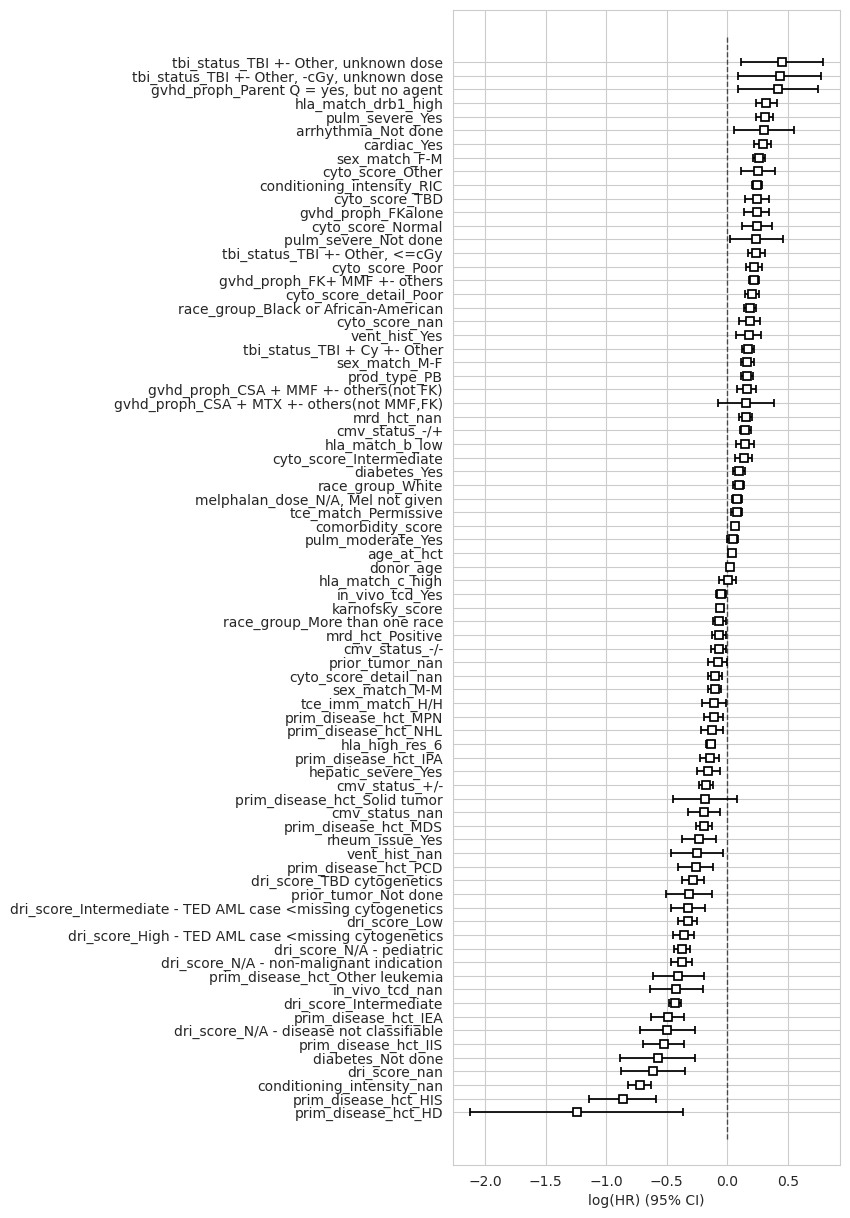

In [99]:
plt.figure(figsize=(5, 15))
cph2.plot()
plt.show()